# XSOR Project - task 2: Trending asset into mean reverting asset

Trending assets are those whose prices or returns display a sustained movement in one direction (upward or
downward) over time. Trending assets are typically non-stationary, meaning their statistical properties (e.g.,
mean, variance) evolve over time. This poses challenges for many standard financial analyses, which assume
stationarity.

In this part of the project, instead of analyzing an already mean-reverting asset, our task was to transform a
trending financial asset into one that exhibits mean-reverting behavior through mathematical or statistical normalization
techniques.

## Graphical introduction: heikin ashi candlestick plot              *I'd remove this part*

**OHLC Data** (Open, High, Low, Close) is a format in financial data analysis that captures key price points of an
asset for a given timeframe (e.g., minute, hour, day). Similar to a bar chart, an OHLC candlestick chart displays
the market’s opening, highest, lowest, and last prices for a given timeframe. The candlestick comprises a broader
section known as the ”real body.”

This real body signifies the price range between the opening and closing prices.  
If the real body is filled or colored <span style="color:red;"><b>red</b></span>, it signifies that the closing price was lower than the opening price.  
Conversely, when the real body is <span style="color:green;"><b>green</b></span>, it indicates that the closing price exceeded the opening price.

"""
<p align="center">
  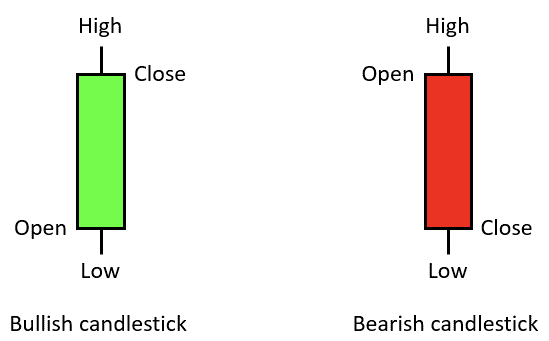
</p>
"""

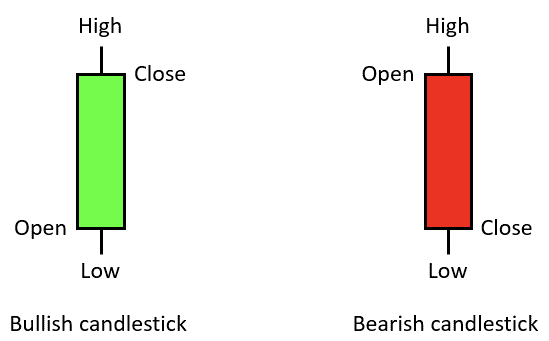

**Heiken- Ashi**: A useful way to visualize trends is by mean of Heiken-Ashi candlesticks. Heiken Ashi (HA) is
a modified candlestick charting technique used in technical analysis to smooth out price action and highlight
trends more clearly. It modifies the traditional Open, High, Low, Close (OHLC) data with a specific formula,
creating a visual representation that filters out some market noise.
The Heiken Ashi (HA) values are calculated as follows:

#### HA Close:
$$
HA\_Close_t = \frac{Open_t + High_t + Low_t + Close_t}{4}
$$

#### HA Open:
$$
HA\_Open_t = \frac{HA\_Open_{t-1} + HA\_Close_{t-1}}{2}
$$
For the first period, the standard \( Open_t \) is used as the starting value.

#### HA High:
$$
HA\_High_t = \max(High_t, HA\_Open_t, HA\_Close_t)
$$

#### HA Low:
$$
HA\_Low_t = \min(Low_t, HA\_Open_t, HA\_Close_t)
$$

HA candles are useful for identifying trends and reversal signals. At a high level, they can be interpreted as follows:

- **Bullish Trends:** Candles with large bodies and no lower wicks typically indicate strong upward trends.
- **Bearish Trends:** Candles with large bodies and no upper wicks typically indicate strong downward trends.
- **Reversal Signals:** Small bodies with both upper and lower wicks may indicate a potential reversal or consolidation.


Here is an example graph:

![An example of trending asset](Fig/trades2.png "An example of trending asset")

However, for the future analysis, we will focus only on Closing Prices, as they are less aftected by daily fluctuactions (add resasons ?????)

## Part 1: A metric for mean reversion

### What is mean reversion ?

![An example of trending asset](Fig/closing_prices_plot.png "An example of trending asset") **Figure 3:** An example of a trending asset

A **Trending asset** is an asset whose prices or returns tend to move back toward their historical average or mean over time.

A typical example is the Ornstein-Uhlenbeck process, which models mean-reverting behavior. The equation for the O-U process is:

$$
dX_t = \theta (\mu - X_t) dt + \sigma dW_t
$$

The solution to this SDE is given by:

$$
X_t = X_0 e^{-\theta t} + \mu \left( 1 - e^{-\theta t} \right) + \sigma \int_0^t e^{-\theta(t-s)} dW_s
$$


Where:
- $ X_t $ is the asset price (or return) at time $ t $,
- $ \mu $ is the long-term mean of the process,
- $ \theta $ is the rate at which the process reverts to the mean (also called the speed of mean reversion),
- $ \sigma $ is the volatility of the process,
- $ dW_t $ is a Wiener process or Brownian motion term representing random noise.


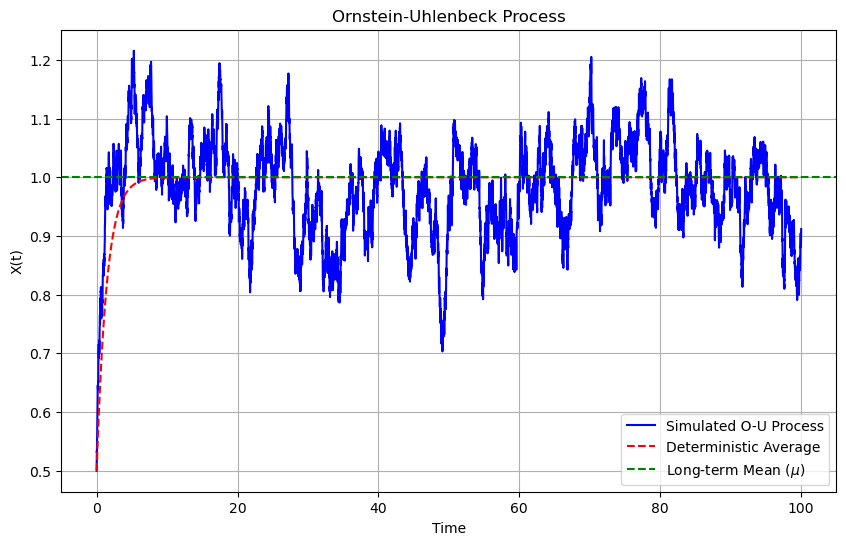

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Ornstein-Uhlenbeck process
theta = 0.7     # rate of mean reversion
mu = 1.0        # long-term mean
sigma = 0.1     # volatility
X0 = 0.5        # initial value
T = 100          # total time
dt = 0.01       # time step
n_steps = int(T / dt)  # number of steps

# Time array
time = np.linspace(0, T, n_steps)

# Initialize the array to store the process values
X = np.zeros(n_steps)
X[0] = X0

# Simulate the Ornstein-Uhlenbeck process
for t in range(1, n_steps):
    dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
    X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW

# Analytical solution for comparison
X_analytical = X0 * np.exp(-theta * time) + mu * (1 - np.exp(-theta * time))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, X, label="Simulated O-U Process", color="blue")
plt.plot(time, X_analytical, label="Deterministic Average", color="red", linestyle='dashed')
plt.axhline(mu, color="green", linestyle="--", label="Long-term Mean ($\mu$)")
plt.title("Ornstein-Uhlenbeck Process")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

Developing a metric for mean reversion is the task of group 1. We will focus instead on predifined test to determine if our dataset is trending or not in a given timewindow. In a second moment we will implement an algorithm to cancel this trend.

## Statistical tests

The removal of the trend from the data is performed by applying an algorithm to them. <br>
In this project we were asked for an empirical implementation of such an algorithm. In fact, there are countless examples in the literature that show the difficulties and precautions needed in modeling this type of data (e.g. https://doi.org/10.2307/1183489), and therefore in using rigorous approaches.<br> 
By not being rigorous, the algorithm we will build will alter, at least partially, the information contained in the data. Therefore, to minimize this modification, the processing is applied only to the regions where there appears to be a trend. These regions must therefore be identified.<br>
To this end, one of the metrics developed by group 1 could be used, but they depend on the efficiency with which the data are detrended. Predefined tests are then used, since this is a preliminary procedure that will then be strengthened by the feedback mechanism granted by applying the metric of group 1, at the end of the work, to the detrended data.

### Fitlering the signal

Before every test we apply we always filter the signal.

To do so we implemented a function that discarts a certain fraction of the high frequency by selecting a certain Area Under the Curve of the power spectrum to remove (in this case we chose 0.01).

In [ ]:
#Import and clean data
from functions import filter_signal, filter_signal_by_auc, import_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from hurst import compute_Hc

# Example usage:
# Load the data
_, close_data = import_data("data_M15/FTSE100_M15_201912230600_202411131015.csv") #"data_M15/DJ_M15_202009240845_202411131015.csv"

# Select the data range for analysis
t_min = 1500
t_max = 2000

# Extract the signal and its datetime index
sig = close_data[t_min:t_max]
datetime_index = close_data.index[t_min:t_max]

# Call the filter_signal function from functions module
#filtered_sig_series = functions.filter_signal(sig, datetime_index, time_step=15*60, freq_factor=10)
filtered_sig_series=filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.01, plot_spectrum=True)
filter_signal(sig, datetime_index)

# Plot the original and filtered signal
plt.figure(figsize=(6, 5))
plt.plot(datetime_index, sig, label='Original signal')
plt.plot(datetime_index, filtered_sig_series, linewidth=3, label='Filtered signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.title("Filtered signal")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Hurst exponent**

The **Hurst exponent**, denoted as $ H $, is a statistical measure used to evaluate the long-term memory of time series data. It helps in understanding the behavior of financial time series, indicating whether they are mean-reverting, trending, or following a random walk.

##### Interpretation of Hurst Exponent Values

The value of the Hurst exponent ranges from 0 to 1 and can be interpreted as follows:

- *$$ H < 0.5 $$*: Indicates **mean-reverting behavior**. This suggests that the time series tends to revert back to its average over time. For example, a stock price that oscillates around its mean without sustaining a prolonged trend would exhibit this behavior.
  
- *$$ H = 0.5 $$*: Suggests that the time series behaves like a **Geometric Brownian Motion**, implying no clear trend and resembling a random walk.

- *$$ H > 0.5 $$*: Indicates **trending behavior**. In this case, high values are likely to be followed by more high values, suggesting persistence in the direction of movement.

##### Mathematical Background

The Hurst exponent is defined mathematically in terms of the rescaled range $ R(n) $ and standard deviation $ S(n) $ of the time series:

$$
\mathbb{E}\left[\frac{R(n)}{S(n)}\right] = C n^H \quad \text{as } n \to \infty
$$


Where:
- $ R(n) $: The range of the first $ n $ cumulative deviations from the mean.
- $ S(n) $: The standard deviation of the first $ n $ observations.
- $ C $: A constant.


##### ~~Applications in Financial Markets~~

~~In finance, the Hurst exponent can be used to develop trading strategies based on whether a market is trending or mean-reverting. Traders can capitalize on mean-reverting behavior by buying low and selling high when prices deviate from their average.~~

~~Understanding the Hurst exponent is crucial for analyzing market behavior and making informed trading decisions based on statistical properties of financial time series data.~~

## ~~Our idea~~

Our first idea has been to employ this metric to determine the intervals where data seem to be trending. It can also be used to find an "optimal" interval to perform ~~rolling means~~ the detrending: anticipating what we will discuss later, a possible strategy to remove trends from the data is to assume it is linear, perform a linear regression and subtract the values of the resulting line from the data; the trend is assumed linear since there is not enough information to consider other types of dependencies as reasonable and avoid overfitting. This procedure, however, requires a method to determine the optimal interval on which to perform the regression.

We computed a "rolling" version of the Hurst exponent over different periods. We then compute the minima ~~and apply a rolling mean with this timewindow~~.

##### Application to the filtered signal

In [4]:
filtered_sig=filtered_sig_series
H_rollv=[]
H_v=[]
x=np.linspace(2,300)
for window in x:
    filtered_new=(filtered_sig-filtered_sig.rolling(window=int(window)).mean()) #Rolling mean over window
    filtered_sig_no_nan = filtered_new[~np.isnan(filtered_new)] #Remove NaN values
    H_roll, c, data=compute_Hc(filtered_sig_no_nan,kind='random_walk', simplified=False) #Compute Hurst exponent
    H, c, data = compute_Hc(filtered_sig,kind='random_walk', simplified=False)
    H_rollv.append(H_roll)

Minimum for x = 8.081632653061224 
H_min = 0.5008001549921817


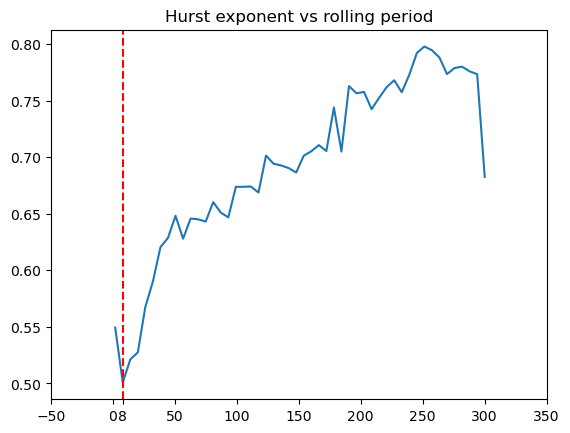

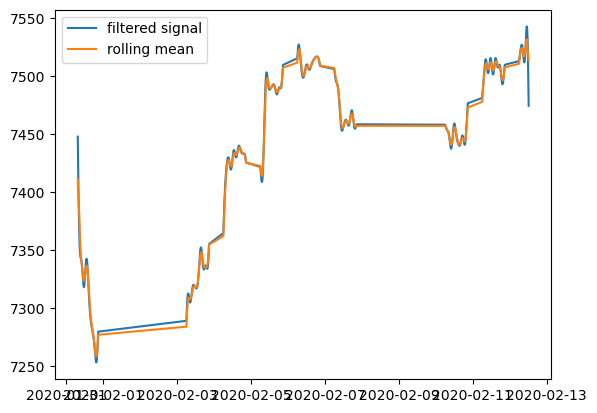

In [5]:
# Plot the Hurst exponent vs rolling period
plt.plot(x, H_rollv)
plt.title("Hurst exponent vs rolling period")

# Find the x-value and y-value corresponding to the minimum of H_rollv
xmin = x[np.argmin(H_rollv)]
Hmin = H_rollv[np.argmin(H_rollv)]

# Print the minimum point
print("Minimum for x =", xmin, "\nH_min =", Hmin)

# Plot a red vertical line at x = xmin
plt.axvline(x=xmin, color='red', linestyle='--')

# Get the current x-ticks
current_ticks = plt.gca().get_xticks()

# Add xmin to the current ticks
new_ticks = np.append(current_ticks, xmin)

# Set the new x-ticks (including the previous ones and xmin)
plt.xticks(new_ticks)

# Display the plot
plt.show()


plt.plot(filtered_sig, label="filtered signal")
plt.plot(filtered_sig.rolling(window=int(xmin), min_periods=1, center=True).mean(), label="rolling mean")
plt.legend()
plt.show()

We can see that the idea is not very effective, since the Hurst Exponent is higly sensible on the smalloscillation of the data of the data, as we will see next.


#Check this !!!!

## Issues

We found out that the Hurst exponent can't be considered as a reliable measure of mean revertness. In fact it measures long term behaviors of the time series, but these don't necessary concide with mean-revertness.

An example is provided below, where various sinosoidal timeseries have been generated and trend/ noise has been added to some of them.
Finally the relative Hurst exponents have been computed over a timewindow of N=5000 timesteps, but 

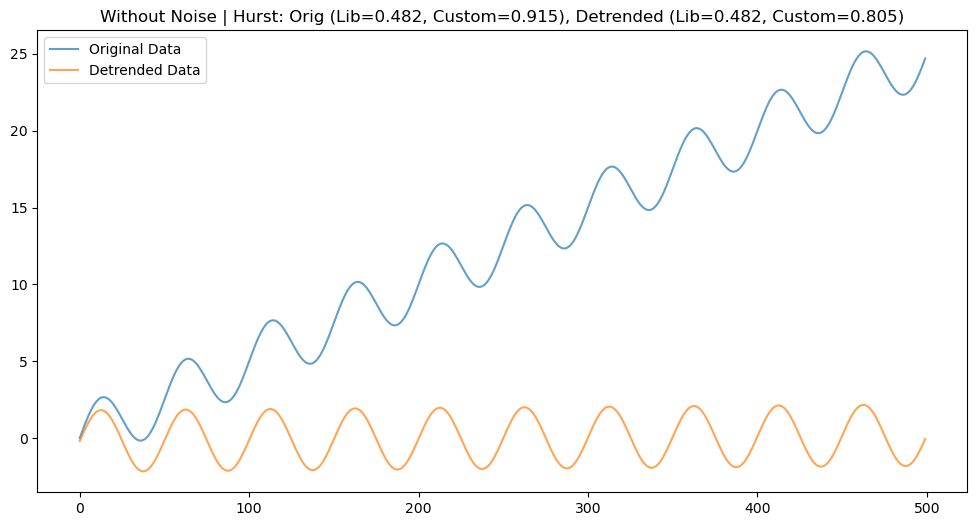

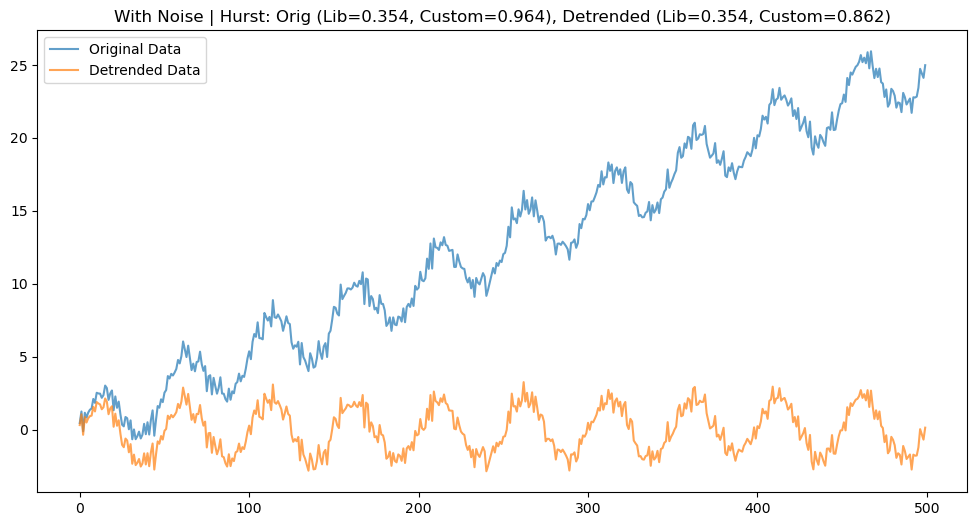

In [2]:
#Trial for final explaination

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from hurst import compute_Hc

def hurst_exponent(time_series, min_window=10, max_window=100):
    """
    Estimate the Hurst exponent of a time series using Rescaled Range (R/S) analysis.
    
    Parameters:
    - time_series: array-like, the time series to analyze.
    - min_window: int, minimum segment size (m).
    - max_window: int, maximum segment size (m).
    
    Returns:
    - H: float, the estimated Hurst exponent.
    """
    N = len(time_series)
    rs_values = []
    window_sizes = []

    for window_size in range(min_window, min(max_window, N // 2)):
        window_sizes.append(window_size)
        num_windows = N // window_size
        rs_for_window = []

        for i in range(num_windows):
            # Extract the window
            segment = time_series[i * window_size:(i + 1) * window_size]
            
            # Calculate mean and cumulative deviation
            mean = np.mean(segment)
            cumulative_deviation = np.cumsum(segment - mean)
            
            # Calculate range (R) and standard deviation (S)
            R = np.max(cumulative_deviation) - np.min(cumulative_deviation)
            S = np.std(segment)
            
            if S > 0:
                rs_for_window.append(R / S)

        # Average R/S across all windows
        if rs_for_window:
            rs_values.append(np.mean(rs_for_window))

    # Fit a line to log-log plot to estimate H
    log_window_sizes = np.log(window_sizes)
    log_rs_values = np.log(rs_values)
    H, _ = np.polyfit(log_window_sizes, log_rs_values, 1)

    return H

def generate_series(n, trend_slope=0.1, oscillation_amplitude=1.0, noise_level=0.0):
    t = np.arange(n)
    trend = trend_slope * t
    oscillation = oscillation_amplitude * np.sin(2 * np.pi * t / 50)
    noise = np.random.normal(scale=noise_level, size=n)
    return trend + oscillation + noise

def linear_detrend(series):
    t = np.arange(len(series))
    slope, intercept, _, _, _ = linregress(t, series)
    return series - (slope * t + intercept)

def analyze_series(data, title_prefix):
    hurst_lib, _, _ = compute_Hc(data, kind='random_walk', simplified=False)
    hurst_custom = hurst_exponent(data)
    detrended_data = linear_detrend(data)
    hurst_lib_detrended, _, _ = compute_Hc(detrended_data, kind='random_walk', simplified=False)
    hurst_custom_detrended = hurst_exponent(detrended_data)
    
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", alpha=0.7)
    plt.plot(detrended_data, label="Detrended Data", alpha=0.7)
    plt.legend()
    plt.title(f"{title_prefix} | Hurst: Orig (Lib={hurst_lib:.3f}, Custom={hurst_custom:.3f}), "
              f"Detrended (Lib={hurst_lib_detrended:.3f}, Custom={hurst_custom_detrended:.3f})")
    plt.show()

np.random.seed(42)
N=500 #length of time series
data_clean = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.0)
analyze_series(data_clean, "Without Noise")
data_noisy = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.5)
analyze_series(data_noisy, "With Noise")

### Alternative approach ###


# Adff, Ktss tests (?)

Why moving average don't work well. Show it actually doesn't work: Detrend data using different interval and analyse the variance of the data.

Compare it with the variance of the preprocessed data.

## Rolling mean

We now further analyse the rolling mean approach and in particular why we excluded this road

In [4]:
def filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.1,plot_spectrum=False):
    """
    Filters the input signal by removing high-frequency components based on the area under the curve (AUC).

    Parameters:
    sig (array-like): The signal to be filtered.
    datetime_index (pd.DatetimeIndex): The datetime index for the signal.
    time_step (float): The time step (in seconds) between each data point (default is 15 minutes).
    discard_fraction (float): Fraction of the total power to discard (default is 10%).

    Returns:
    filtered_sig_series (pd.Series): A Pandas Series containing the filtered signal with the datetime index.
    """
    # The corresponding frequencies
    sample_freq = fftfreq(sig.size, d=time_step)
    pos_mask = sample_freq > 0
    freqs = sample_freq[pos_mask]

    # Perform the FFT
    sig_fft = fft(np.array(sig))
    power = np.abs(sig_fft) ** 2

    # Compute cumulative power
    cumulative_power = np.cumsum(power[pos_mask])
    total_power = cumulative_power[-1]
    target_power = (1 - discard_fraction) * total_power

    # Determine the cutoff frequency
    cutoff_idx = np.searchsorted(cumulative_power, target_power)
    cutoff_freq = freqs[cutoff_idx]
    
    print(f"Cutoff frequency: {cutoff_freq:.6f} Hz")

    # Apply the frequency filter
    filtered_fft = sig_fft.copy()
    filtered_fft[np.abs(sample_freq) > cutoff_freq] = 0
    filtered_sig = ifft(filtered_fft)

    # Convert filtered signal to real values (IFFT output might be complex)
    filtered_sig = np.real(filtered_sig)

    # Create a Pandas Series with the datetime index and the filtered signal
    filtered_sig_series = pd.Series(filtered_sig, index=datetime_index)
    
    if(plot_spectrum==True):
        # Plot for visualization
        plt.figure(figsize=(6, 5))
        plt.plot(freqs, np.cumsum(power[pos_mask]) / total_power, label="Cumulative Power")
        plt.axvline(cutoff_freq, color='red', linestyle='--', label=f"Cutoff: {cutoff_freq:.2e} Hz")
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Normalized Cumulative Power')
        plt.title("Cumulative Power Spectrum")
        plt.legend()
        plt.show()

    return filtered_sig_series

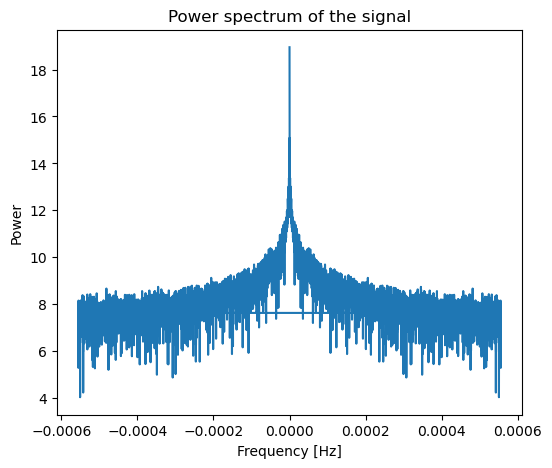

In [13]:
import pandas as pd

#from functions import *
# Load the data
_, close_data = import_data("data_M15/DJ_M15_202009240845_202411131015.csv") #data_M15/FTSE100_M15_201912230600_202411131015.csv"

# We consider a 2 day interval
t_min = pd.to_datetime('2020.09.24 08:45:00')
t_min = close_data.index.get_loc(t_min)


t_max = pd.to_datetime('2020.12.24 08:45:00')
t_max = close_data.index.get_loc(t_max)

# Extract the signal and its datetime index
sig = close_data[t_min:t_max]
datetime_index = close_data.index[t_min:t_max]

# Call the filter_signal function from functions module
#filtered_sig_series = functions.filter_signal(sig, datetime_index, time_step=15*60, freq_factor=10)
filtered_sig_series=filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.01, plot_spectrum=False)
filter_signal(sig, datetime_index);

filtered_sig=filtered_sig_series
H_rollv=[]
H_v=[]
x=np.linspace(2,50)
for window in x:
    filtered_new=(filtered_sig-filtered_sig.rolling(window=int(window)).mean()) #Rolling mean over window
    filtered_sig_no_nan = filtered_new[~np.isnan(filtered_new)] #Remove NaN values
    H_roll, c, data=compute_Hc(filtered_sig_no_nan,kind='random_walk', simplified=False) #Compute Hurst exponent
    H, c, data = compute_Hc(filtered_sig,kind='random_walk', simplified=False)
    H_rollv.append(H_roll)

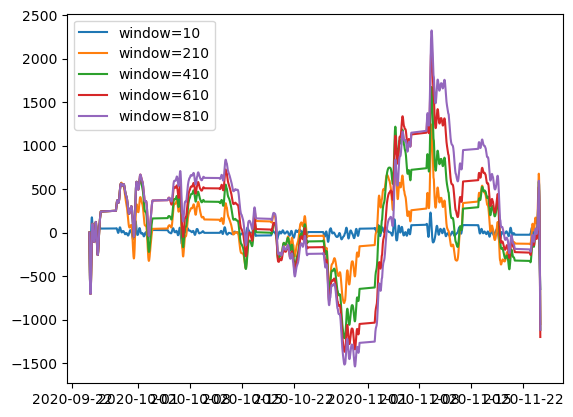

In [97]:
#plt.plot(filtered_sig, label="filtered signal")
for w in range(10,1000,200):
    plt.plot(filtered_sig-filtered_sig.rolling(window=w, min_periods=1, center=False).mean(), label=f"window={w}")
plt.legend()
plt.show()

## Why is this bad ?

Essentially this method detrends the data, but makes us loose information about it. Let's quantify this pehnomena

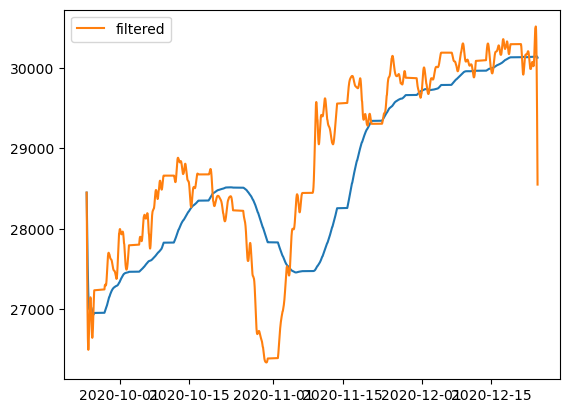

In [14]:
plt.plot(filtered_sig.rolling(window=1000, min_periods=1, center=False).mean())
plt.plot(filtered_sig, label='filtered')
plt.legend()

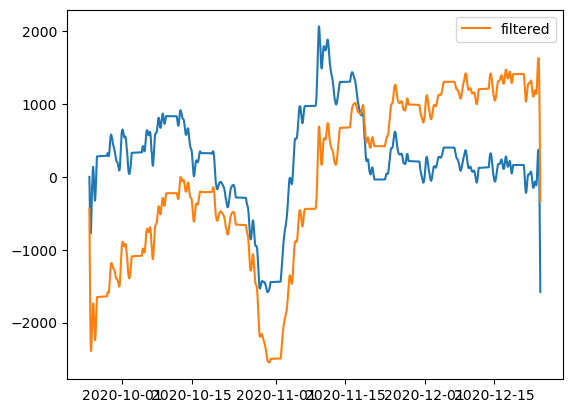

In [16]:
plt.plot(filtered_sig-filtered_sig.rolling(window=1000, min_periods=1, center=False).mean())
plt.plot(filtered_sig-np.mean(filtered_sig), label='filtered')
plt.legend()

### Method1: Shannon Entropy

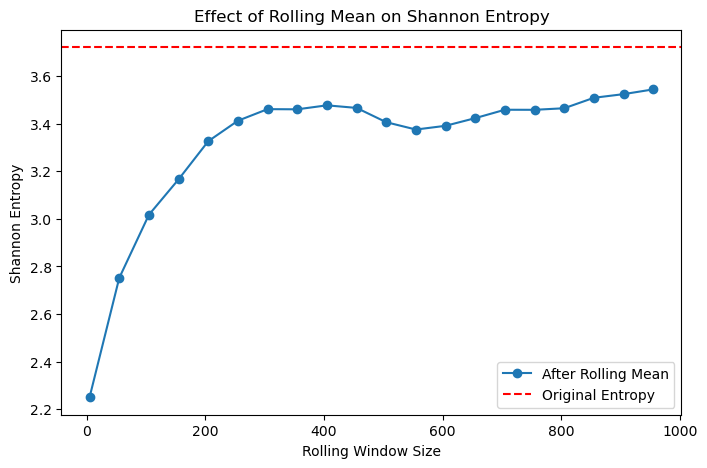

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def shannon_entropy(signal, bins=50):
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero probabilities
    return entropy(hist)

# Define window sizes to test
window_sizes = np.arange(5, 1001, 50)  # From 5 to 1000, step 50
entropy_values = []

original_entropy = shannon_entropy(filtered_sig)

# Compute entropy for different rolling window sizes
for window in window_sizes:
    rolling_signal = filtered_sig - filtered_sig.rolling(window=window, min_periods=1).mean()
    entropy_values.append(shannon_entropy(rolling_signal))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(window_sizes, entropy_values, marker='o', label='After Rolling Mean')
plt.axhline(original_entropy, color='r', linestyle='--', label='Original Entropy')
plt.xlabel("Rolling Window Size")
plt.ylabel("Shannon Entropy")
plt.title("Effect of Rolling Mean on Shannon Entropy")
plt.legend()
plt.show()

### Spectrum analysis

Cutoff frequency: 0.000012 Hz


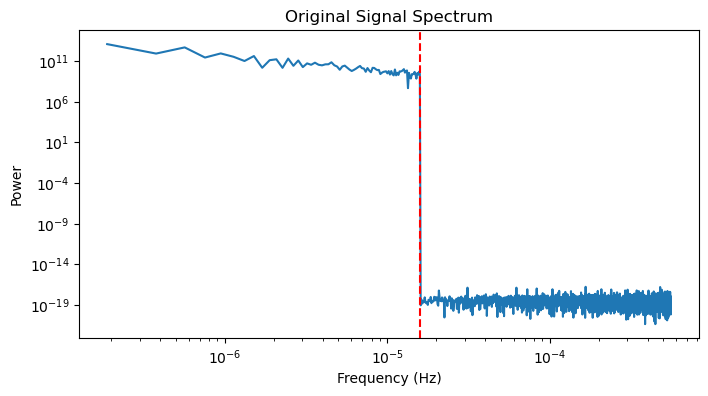

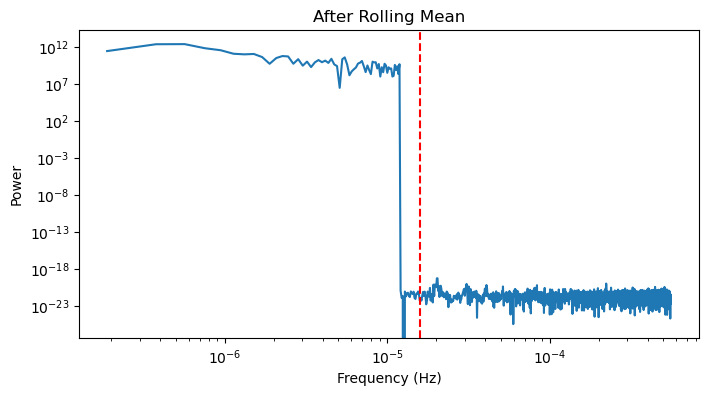

In [171]:
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum(signal, title="Power Spectrum"):
    N = len(signal)
    time_step = 900  # 15 minutes in seconds
    freq = np.fft.fftfreq(N, d=time_step)  # Convert to Hz
    psd = np.abs(np.fft.fft(signal))**2  # Compute power spectral density

    plt.figure(figsize=(8, 4))
    plt.loglog(freq[freq > 0], psd[freq > 0])  # Convert Hz
    plt.axvline(0.000016, color='r', linestyle='--', label='1.6e-6 Hz')  # Vertical line
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(title)
    plt.show()

filtered_sig_final=filter_signal_by_auc(filtered_sig - filtered_sig.rolling(window=1000,min_periods=1).mean(), datetime_index, time_step=15*60, discard_fraction=0.01, plot_spectrum=False)

plot_power_spectrum(filtered_sig, title="Original Signal Spectrum")
plot_power_spectrum(filtered_sig_final, title="After Rolling Mean")

<Figure size 800x400 with 0 Axes>

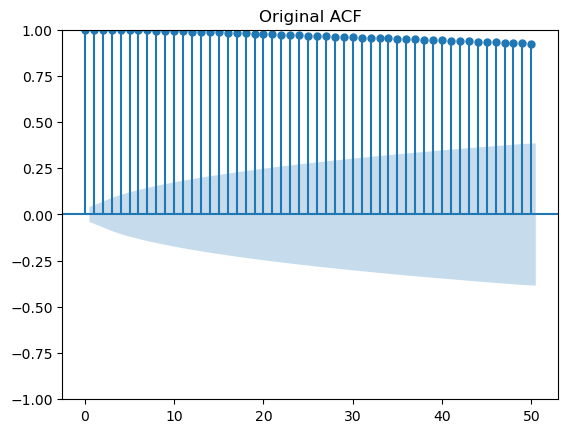

<Figure size 800x400 with 0 Axes>

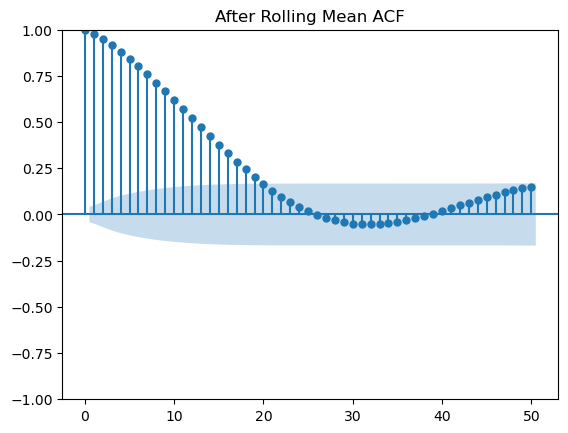

In [51]:
import statsmodels.api as sm

plt.figure(figsize=(8, 4))
sm.graphics.tsa.plot_acf(filtered_sig.dropna(), lags=50, title="Original ACF")
plt.show()

plt.figure(figsize=(8, 4))
sm.graphics.tsa.plot_acf((filtered_sig - filtered_sig.rolling(window=10).mean()).dropna(), lags=50, title="After Rolling Mean ACF")
plt.show()

## Apply Mann-Kendall test

In [32]:
start_index=t_min
end_index=t_max

chunk_size=96*2 #<-->2-days windows
test_result=[]
test_result_filtered=[]
for i in range(0,int((end_index-start_index)/chunk_size)):
    
    s=start_index+i*chunk_size
    e=start_index+(i+1)*chunk_size
    
    prices=np.array(df.loc[df.index[s]:df.index[e],['HA_close']])
    prices=prices.reshape(chunk_size+1)
    time_indices=df.index[s:e+1]
    prices_filtered=filter_signal_by_auc(prices,time_indices,plot_spectrum=False)
    
    trend_test_modified = hamed_rao_modification_test(prices)
    trend_test_modified_filtered = hamed_rao_modification_test(prices_filtered)
    
    if (trend_test_modified[0]=='no trend'):
        test_result.append(0)
    elif (trend_test_modified[0]=='increasing'):
        test_result.append(1)
    else:
        test_result.append(-1)
        
    if (trend_test_modified_filtered[0]=='no trend'):
        test_result_filtered.append(0)
    elif (trend_test_modified_filtered[0]=='increasing'):
        test_result_filtered.append(1)
    else:
        test_result_filtered.append(-1)
    
    lags = int(prices.size/8)
    acf_vals = acf(prices, nlags=lags)

768


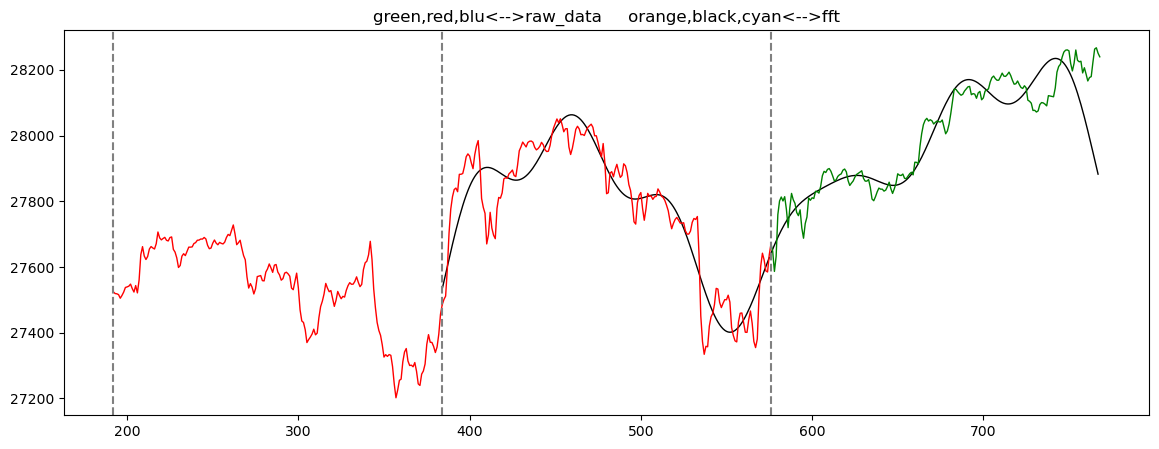

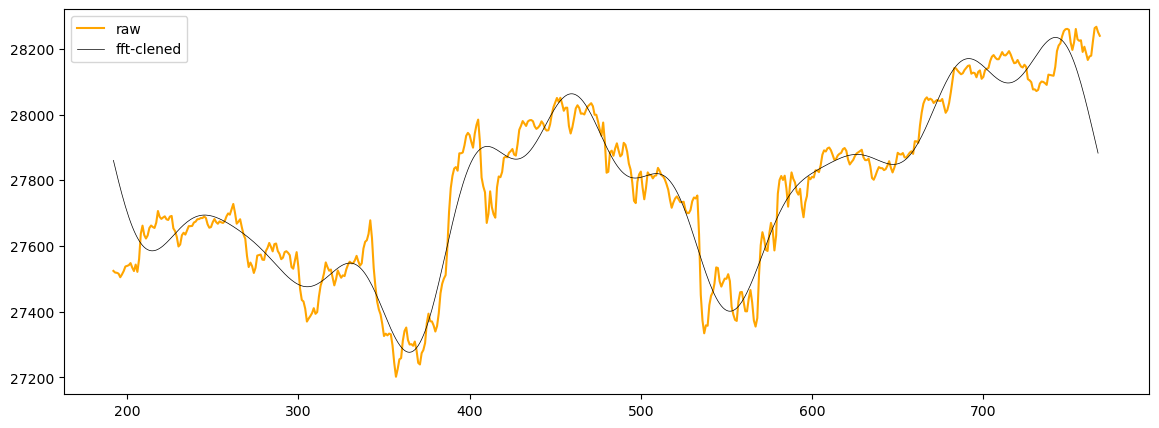

In [35]:
import os
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
from hurst import compute_Hc
from pymannkendall import original_test, hamed_rao_modification_test
from statsmodels.tsa.stattools import acf
from scipy.fftpack import fft, ifft, fftfreq



file = "data_M15/DJ_M15_202009240845_202411131015.csv"
df = pd.read_csv(file,delimiter='\t')
df.rename(columns={
    '<DATE>': 'Date',
    '<TIME>': 'Time',
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<CLOSE>': 'Close',
    '<TICKVOL>': 'TickVol',
    '<VOL>': 'Volume',
    '<SPREAD>': 'Spread'
}, inplace=True)
df['HA_close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
df['HA_open']=df['Open']

df['HA_high'] = df[['High', 'HA_open','HA_close']].apply(max, axis=1)
df['HA_low'] = df[['Low','HA_open','HA_close']].apply(min,axis=1)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y.%m.%d %H:%M:%S')


#Defining starting and endind positions
starting_position=96*2  #2350
if (starting_position!=0):
    start = df.index[starting_position]
else:
    start=pd.to_datetime('2020.09.24 08:45:00')
start_index=df.index.get_loc(start)
end_index=96*8
if (end_index!=0):
    end = df.index[end_index]
    print(end)
else:
    end = pd.to_datetime('2020.10.12 08:45:00')
    end_index=df.index.get_loc(end)

#Implementing the test on non-overlapping adjacent windows
chunk_size=96*2 #<-->2-days windows
test_result=[]
test_result_filtered=[]
for i in range(0,int((end_index-start_index)/chunk_size)):
    
    s=start_index+i*chunk_size
    e=start_index+(i+1)*chunk_size
    
    prices=np.array(df.loc[df.index[s]:df.index[e],['HA_close']])
    prices=prices.reshape(chunk_size+1)
    time_indices=df.index[s:e+1]
    prices_filtered=filter_signal_by_auc(prices,time_indices,plot_spectrum=False)
    
    trend_test_modified = hamed_rao_modification_test(prices)
    trend_test_modified_filtered = hamed_rao_modification_test(prices_filtered)
    
    if (trend_test_modified[0]=='no trend'):
        test_result.append(0)
    elif (trend_test_modified[0]=='increasing'):
        test_result.append(1)
    else:
        test_result.append(-1)
        
    if (trend_test_modified_filtered[0]=='no trend'):
        test_result_filtered.append(0)
    elif (trend_test_modified_filtered[0]=='increasing'):
        test_result_filtered.append(1)
    else:
        test_result_filtered.append(-1)
    
    lags = int(prices.size/8)
    acf_vals = acf(prices, nlags=lags)
    '''plt.figure(figsize=(8, 5))
    plt.bar(range(lags + 1), acf_vals, alpha=0.7, label="ACF Values")
    plt.axhline(1.96/np.sqrt(prices.size), color='red', linestyle='dashed')
    plt.axhline(-1.96/np.sqrt(prices.size), color='red', linestyle='dashed')'''

#Preparing the plotting
df_filtered=df['HA_close'][start:end].copy()
df_filtered= filter_signal_by_auc(df_filtered.values, df_filtered.index)
plt.figure(figsize=(14, 5))
plt.title("green,red,blu<-->raw_data     orange,black,cyan<-->fft")
#Plotting
for i in range(len(test_result)):
    s = start_index + i * chunk_size
    e = s + chunk_size

    # Determine the color based on test_result
    if test_result[i] == 1:
        color = 'green'
    elif test_result[i] == -1:
        color = 'red'
    else:
        color = 'blue'

    if test_result_filtered[i] == 1:
        color_filtered = 'orange'
    elif test_result_filtered[i] == -1:
        color_filtered = 'black'
    else:
        color_filtered = 'cyan'
        
    # Plot the chunk
    plt.plot(df.loc[df.index[s]:df.index[e],['HA_close']], color=color, linewidth=1)
    plt.plot(df_filtered[s:e], color=color_filtered, linewidth=1 )
    plt.axvline(df.index[s], color='grey', linestyle='dashed')


plt.figure(figsize=(14, 5))
plt.plot(df.loc[start:end,['HA_close']], color='orange', label='raw')
plt.plot(df_filtered, label='fft-clened',color='black', linewidth=.5, )
plt.legend()


3.2